The question that this notebook aims to answer is: Are movies that are released in more countries more profitable?

AN executive summary of the entire notebook goes here

business understanding
-talk abotu the project

data mining
-where are u getting alternateive data and why

Data cleaning

Data exploration

Feature Engineering
-throughout the notebook explaining what changes you're making and why

Predictive modelling

Data Visualization



# Import packages and set SQL cursor

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import os
%matplotlib inline

conn = sqlite3.connect('movies_db.sqlite')
cur = conn.cursor()

## Adjust view space

In [238]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Bring in data from our SQL database

## Creating our Countries per Movie DataFrame

In [239]:
conn.execute("select name from sqlite_master where type='table';").fetchall()

[('bom_movie_gross',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [240]:
cur.execute('''SELECT primary_title, region
                FROM imdb_title_akas a
                JOIN imdb_title_basics b
                ON a.title_id = b.tconst
                ;''')
df_title_region = pd.DataFrame(cur.fetchall())
df_title_region.columns = [x[0] for x in cur.description]
df_title_region.head()

,primary_title,region
0,Sunghursh,IN
1,Sunghursh,None
2,Sunghursh,IN
3,Sunghursh,IN
4,Sunghursh,IN


## Creating our Movie Budgets and Revenues DataFrame 

In [241]:
cur.execute('''SELECT * 
                FROM tn_movie_budgets
                ;''')
df_movie_moneys = pd.DataFrame(cur.fetchall())
df_movie_moneys.columns = [x[0] for x in cur.description]
df_movie_moneys.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Data Cleaning

## Cleaning & Counting - Countries per Movie

dropped NoneType values from region column
-grouped by the primary title and was able to find a way to capture the aggregated string values by casing them individually as a list and creating a new column called 'country_list'
-Originally had this in many more lines of code, running a lambda function through the column with .map(lambda x: list(x)).  ---The code below is uch more efficient and also resets the index!
--updated df name to be more descriptive

In [242]:
df_title_region = df_title_region.dropna()

df_title_regionlist = df_title_region.groupby('primary_title')['region'].apply(list).reset_index(name='country_list')
df_title_regionlist.head()

,primary_title,country_list
0,!Women Art Revolution,"[XWW, RU, US]"
1,#1 Serial Killer,[US]
2,#5,[US]
3,#50Fathers,[US]
4,#66,[ID]


The above code led to a much better optimization for creating a new column with the number of countries each movie was released in
-- Just making each value be the length of the list in the previous column with some nice list comprehension
--updated df name to be more descriptive

In [243]:
df_title_regionlist['country_count'] = [len(x) for x in df_title_regionlist['country_list']]
df_title_regionlist_ccount = df_title_regionlist
df_title_regionlist_ccount.head()

,primary_title,country_list,country_count
0,!Women Art Revolution,"[XWW, RU, US]",3
1,#1 Serial Killer,[US],1
2,#5,[US],1
3,#50Fathers,[US],1
4,#66,[ID],1


I wantd to subset the list by movies that were either domestic releases or international.  This is a significant step as it breaks out entire dataset in two.  We can now have two very comparable datasets and do a lot of investigating and contrasting of theories.

--only include movies that have one country count
--reassign variable to avoid a slice/copy message
--lots of ways to rearrange the data in this set.  Can decide which way is best for merging/joining with financial information.

In [244]:
df_domestic_title_country = df_title_regionlist_ccount[
    df_title_regionlist_ccount[
        'country_count'
    ] == 1
]

df_domestic_title_country = df_domestic_title_country.drop('country_count', axis=1)
# Reassigned variable to avoid 'A value is trying to be set on a copy of a slice from a DataFrame.' error.
df_domestic_title_country['country_list'] = df_domestic_title_country['country_list'].map(lambda x: ''.join(x))
df_domestic_title_country.head()

,primary_title,country_list
1,#1 Serial Killer,US
2,#5,US
3,#50Fathers,US
4,#66,ID
5,#BKKY,TH


We can see which domestic movies were released by each country

In [245]:
df_domestic_country_movie_list = df_domestic_title_country.groupby('country_list')['primary_title'].apply(list).reset_index(name='movie_list')
df_domestic_country_movie_list.head()

,country_list,movie_list
0,AD,"[73', Impacto]"
1,AE,"[11 Days, 4th G - The Ground Level, A Tale of ..."
2,AF,"[A Man's Desire for Fifth Wife, Afghanistan, A..."
3,AG,"[Jed Video, Redemption of Paradise, The Making..."
4,AI,[Perihelion]


Or we can just see how many domestic movies per country.

In [246]:
df_dom_movies_per_country = df_domestic_title_country
df_dom_movies_per_country['movies_per_country'] = 1
df_dom_movies_per_country = df_domestic_title_country.groupby('country_list').sum()
df_dom_movies_per_country.head()

,movies_per_country
country_list,
AD,2
AE,53
AF,27
AG,8
AI,1


Next we wanted to make a complete list of the international movies, those with more than 1 in their country count.
reset the index just to make it look nicer and for potential merging/joining issues later.

In [247]:
df_int_title_clist_ccount = df_title_regionlist_ccount[
    df_title_regionlist_ccount[
        'country_count'
    ] > 1
]

df_int_title_clist_ccount = df_int_title_clist_ccount.reset_index().drop('index', axis=1)
df_int_title_clist_ccount.head()

,primary_title,country_list,country_count
0,!Women Art Revolution,"[XWW, RU, US]",3
1,#Bicyclediary,"[FI, XWW]",2
2,#Female Pleasure,"[LT, PL, DE, CH, ES]",5
3,#FollowFriday,"[US, FR, BR]",3
4,#Horror,"[US, XWW, US, RU]",4


## Cleaning and Counting - Domestic and International Profits

Get some information about this data set and see if anything looks off

In [248]:
print(df_movie_moneys.info())
df_movie_moneys.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.1+ KB
None


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [249]:
df_movie_moneys = df_movie_moneys.drop('id', axis=1)
df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


   First thing is to clean and convert the three columns: production_budget, domestic_gross, and worldwide_gross from strings to floats.
   
-- I created a function to solve this as it may be that we need this again if we bring in any other data containing similar columns, also can be recreated for my teammates

--  

In [253]:
def string_to_float_converter(value, to_replace=None, new_value='', new_dtype=float):
    
    '''This function cleans and converts any column of strings with UP TO 3
    variables at a time. This function is designed to be mapped along columns
    in a Pandas DataFrame and takes in a (value) and the desired string characters
    to be replacesd (to_replace). By default the new_value is set as a blank '',
    though it can be altered if needed. Additionally, the default (new_dtype) 
    is set as a 'float' but othertypes may be chosen as well.''' 
    
    
    if type(to_replace) == list:
        n = len(to_replace)
        if n == 2:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value))
        if n == 3:
            return new_dtype(value.replace(to_replace[0], new_value).replace(to_replace[1], new_value).replace(to_replace[2]))
    else:
        return new_dtype(value.replace(to_replace, new_value))

df_movie_moneys['worldwide_gross'] = df_movie_moneys['worldwide_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
df_movie_moneys['production_budget'] = df_movie_moneys['production_budget'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))
df_movie_moneys['domestic_gross'] = df_movie_moneys['domestic_gross'].map(lambda x: string_to_float_converter(x, to_replace=['$',',']))

df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


convert the release date column to date objects

In [254]:
df_movie_moneys['release_date'] = pd.to_datetime(df_movie_moneys['release_date'])
df_movie_moneys.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


In [255]:
df_movie_moneys.describe()

,production_budget,domestic_gross,worldwide_gross
count,5.782000e+03,5.782000e+03,5.782000e+03
mean,3.158776e+07,4.187333e+07,9.148746e+07
std,4.181208e+07,6.824060e+07,1.747200e+08
min,1.100000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,1.429534e+06,4.125415e+06
50%,1.700000e+07,1.722594e+07,2.798445e+07
75%,4.000000e+07,5.234866e+07,9.764584e+07
max,4.250000e+08,9.366622e+08,2.776345e+09


I want to clean this up a little, get rid of the rows that have both $0 domestic & $0 worldwide gross. I will leave in movies that made either as having 'flops' in the data may be insightful. A lot of the movies included in here weren't even released yet, so that makes me think that perhaps there were some older movies on this list that were never even made.  I hate to drop 5% but I want better numbers than above.

In [256]:
df_movie_moneys = df_movie_moneys[(df_movie_moneys['worldwide_gross'] != 0)]
print(df_movie_moneys.describe())
df_movie_moneys.head()

       production_budget  domestic_gross  worldwide_gross
count       5.415000e+03    5.415000e+03     5.415000e+03
mean        3.330801e+07    4.471128e+07     9.768800e+07
std         4.248758e+07    6.960989e+07     1.788591e+08
min         1.100000e+03    0.000000e+00     2.600000e+01
25%         6.000000e+06    3.160708e+06     7.004834e+06
50%         1.900000e+07    2.030022e+07     3.333987e+07
75%         4.200000e+07    5.578249e+07     1.044590e+08
max         4.250000e+08    9.366622e+08     2.776345e+09


,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


Last thing is to change the column name from 'movie' to 'primary_title' so as to make future merges less stressful!

In [257]:
df_movie_moneys = df_movie_moneys.rename(columns={'movie':'primary_title'})
df_movie_moneys

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
5,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
6,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
7,2007-05-24,Pirates of the Caribbean: At Worldâs End,300000000.0,309420425.0,9.634204e+08
8,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08
9,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08


       production_budget  domestic_gross  worldwide_gross
count       5.415000e+03    5.415000e+03     5.415000e+03
mean        3.330801e+07    4.471128e+07     9.768800e+07
std         4.248758e+07    6.960989e+07     1.788591e+08
min         1.100000e+03    0.000000e+00     2.600000e+01
25%         6.000000e+06    3.160708e+06     7.004834e+06
50%         1.900000e+07    2.030022e+07     3.333987e+07
75%         4.200000e+07    5.578249e+07     1.044590e+08
max         4.250000e+08    9.366622e+08     2.776345e+09


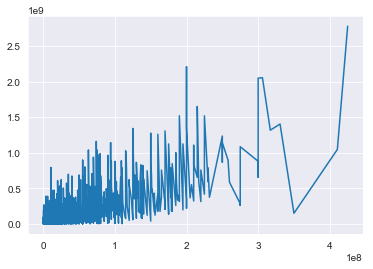

In [292]:
print(df_movie_moneys.describe())
plt.plot(df_movie_moneys['production_budget'], df_movie_moneys['worldwide_gross'])

# Data Exploration & Feature Engineering

Let's start be looking at the international movies and how they did financially

We start this by merging the two dataframes togeher using the primary_title

In [300]:
df_int_movies_analysis = df_movie_moneys.merge(df_country_list_int, on='primary_title')
df_int_movies_analysis.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,"[JP, XWW]",2
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[JP, SE, PE, UA, US, RO, CA, BG, TR, GE, IL, U...",45
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[FR, MX, IT, PL, HU, PT, US, BG, EE, GB, BD, V...",34
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[AZ, PE, US, IL, MX, US, LT, CA, AR, DE, BR, G...",40
4,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[AR, ES, RS, XWW, US, ES, CZ, UY, BG, US, US, ...",37


# OUTLIER CHANGES

In [ ]:
df_int_movies_analysis = df_int_movies_analysis[df_int_movies_analysis['']]

In [327]:
df_int_movies_analysis['foreign_gross'] = df_int_movies_analysis['worldwide_gross'] - df_int_movies_analysis['domestic_gross']
df_int_movies_analysis['domestic_profit'] = df_int_movies_analysis['domestic_gross'] - df_int_movies_analysis['production_budget']
# df_int_movies_analysis['foreign_profit'] = df_int_movies_analysis['foreign_gross'] - df_int_movies_analysis['production_budget']
df_int_movies_analysis['total_profit'] = df_int_movies_analysis['worldwide_gross'] - df_int_movies_analysis['production_budget']
df_int_movies_analysis['return_on_investment'] = df_int_movies_analysis['worldwide_gross'] / df_int_movies_analysis['production_budget']

df_int_movies_analysis

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,"[JP, XWW]",2,2.015838e+09,335507625.0,2.351345e+09,6.532577
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[JP, SE, PE, UA, US, RO, CA, BG, TR, GE, IL, U...",45,8.046000e+08,-169536125.0,6.350639e+08,2.546673
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[FR, MX, IT, PL, HU, PT, US, BG, EE, GB, BD, V...",34,1.070000e+08,-307237650.0,-2.002376e+08,0.427892
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[AZ, PE, US, IL, MX, US, LT, CA, AR, DE, BR, G...",40,9.440081e+08,128405868.0,1.072414e+09,4.243841
4,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[AR, ES, RS, XWW, US, ES, CZ, UY, BG, US, US, ...",37,1.369319e+09,378815482.0,1.748134e+09,6.827114
5,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,"[RS, AR, US, HU, VN, IL, IT, LT, EE, US, HR, S...",32,4.269209e+08,-70975705.0,3.559452e+08,2.186484
6,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,"[BG, PT, RS, RU, LV, UA, XWW, CZ, SE, LT, AU, ...",32,6.795467e+08,-99925825.0,5.796209e+08,2.932070
7,2012-07-20,The Dark Knight Rises,275000000.0,448139099.0,1.084439e+09,"[SI, LT, UY, JP, US, LV, US, US, RS, AR, BG, H...",50,6.363000e+08,173139099.0,8.094391e+08,3.943415
8,2018-05-25,Solo: A Star Wars Story,275000000.0,213767512.0,3.931513e+08,"[SE, RS, HU, LT, RO, CL, TR, UA, SK, US, CA, C...",35,1.793838e+08,-61232488.0,1.181513e+08,1.429641
9,2013-07-02,The Lone Ranger,275000000.0,89302115.0,2.600021e+08,"[IT, UA, SK, VE, PT, DE, CA, RS, AR, SI, CZ, H...",34,1.707000e+08,-185697885.0,-1.499788e+07,0.945462


<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked
<class 'list'>
<class 'pandas.core.series.Series'>
worked


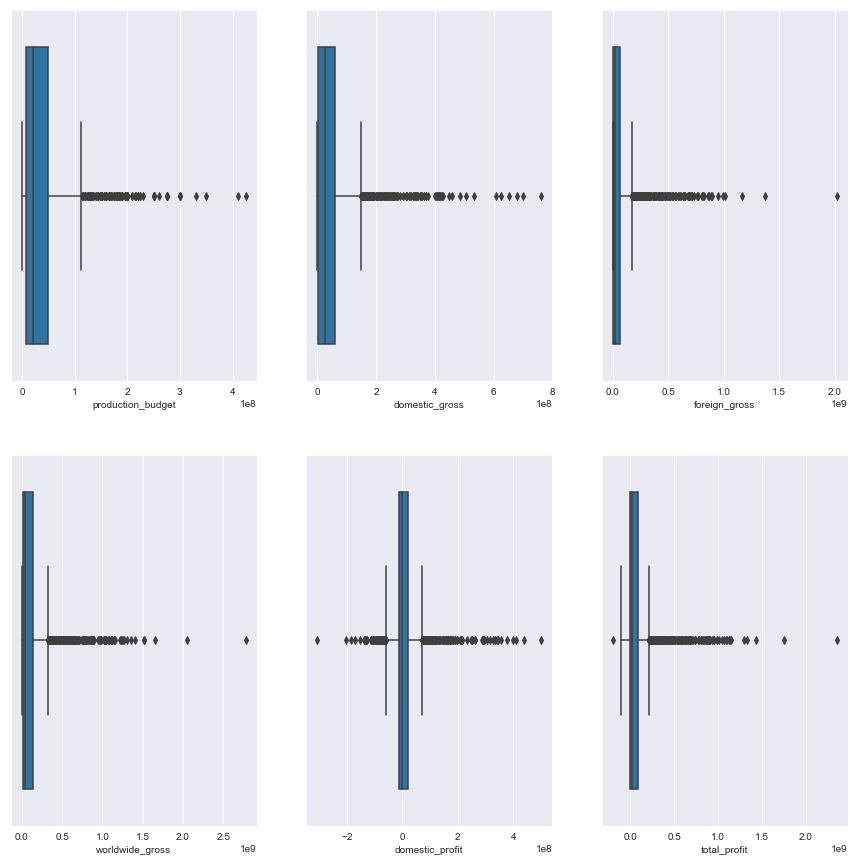

In [302]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

y = df_int_movies_analysis['country_count']
x = [df_int_movies_analysis['production_budget'], df_int_movies_analysis['domestic_gross'], df_int_movies_analysis['foreign_gross'],
     df_int_movies_analysis['worldwide_gross'], df_int_movies_analysis['domestic_profit'], df_int_movies_analysis['total_profit']]
z = ['production_budget', 'domestic_gross', 'foreign_gross',
     'worldwide_gross', 'domestic_profit', 'foreign_profit',
     'total_profit']

for n in range(1,7):
    row = (n-1)//3
    col = n%3-1
    ax = axes[row][col]
    x1 = x[n-1]
    print(type(x))
    print(type(y))
    sns.set_style('darkgrid')
    sns.boxplot(x1, ax=ax)
    print('worked')

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


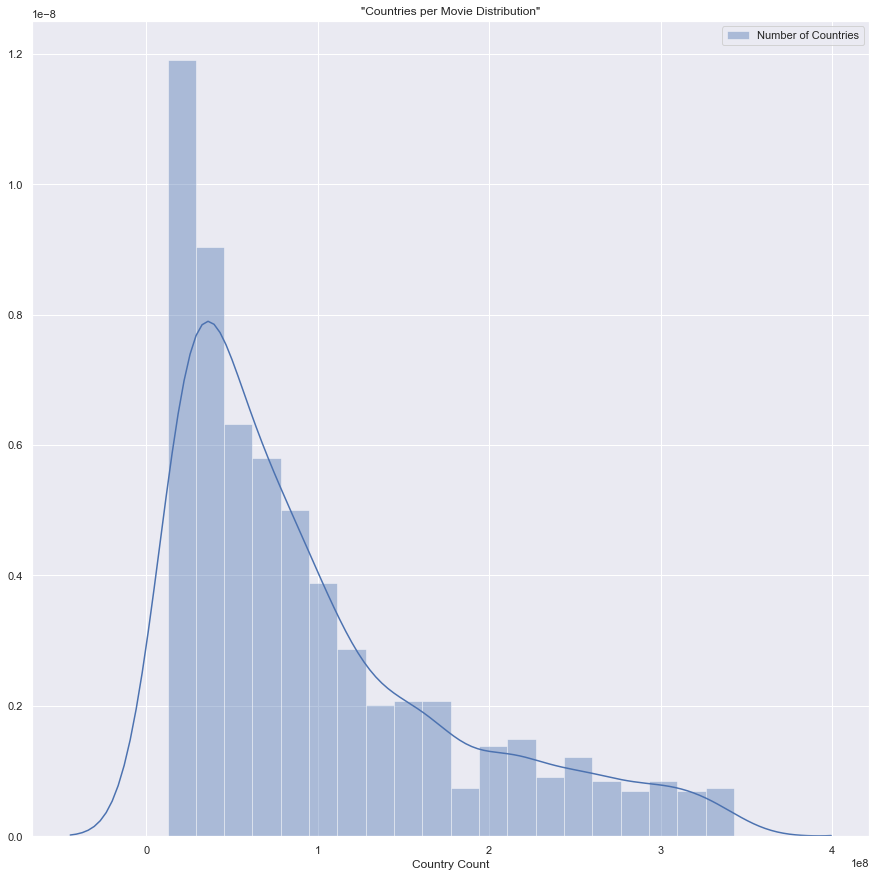

In [438]:
plt.figure(figsize=(15,15))
# sns.set(context=, style=, palette=, font=, font_scale=, color_codes=, rc=,)

bins=[2,12,22,32,42,52,62,72,82]
column = df_int_movies_analysis\
[(df_int_movies_analysis['worldwide_gross']\
 > df_int_movies_analysis['worldwide_gross'].quantile(.3))\
 & (df_int_movies_analysis['worldwide_gross']\
 < df_int_movies_analysis['worldwide_gross'].quantile(.9))]\
['worldwide_gross']
sns.distplot(column, bins=20, norm_hist=True, axlabel='Country Count');

plt.xticks()
plt.title('"Countries per Movie Distribution"')
plt.legend(['Number of Countries'])

In [389]:
def country_count_category(value):
    if value <=10:
        value = '10 or less'
    elif value > 10 and value <= 20:
        value = '11 - 20'
    elif value > 20 and value <= 30:
        value = '21 - 30'
    elif value > 40 and value <= 50:
        value = '31 - 40'
    elif value > 50 and value <= 60:
        value = '41 - 50'
    elif value > 60 and value <= 70:
        value = '51 - 60'
    else:
        value = '70 +'
    return value
    
df_int_movies_analysis['country_count_category'] = df_int_movies_analysis['country_count'].map(lambda x: country_count_category(x))
df_int_movies_analysis.head()

,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,country_list,country_count,foreign_gross,domestic_profit,total_profit,return_on_investment,country_count_category
0,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,"[JP, XWW]",2,2.015838e+09,335507625.0,2.351345e+09,6.532577,10 or less
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,"[JP, SE, PE, UA, US, RO, CA, BG, TR, GE, IL, U...",45,8.046000e+08,-169536125.0,6.350639e+08,2.546673,31 - 40
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,"[FR, MX, IT, PL, HU, PT, US, BG, EE, GB, BD, V...",34,1.070000e+08,-307237650.0,-2.002376e+08,0.427892,70 +
3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,"[AZ, PE, US, IL, MX, US, LT, CA, AR, DE, BR, G...",40,9.440081e+08,128405868.0,1.072414e+09,4.243841,70 +
4,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,"[AR, ES, RS, XWW, US, ES, CZ, UY, BG, US, US, ...",37,1.369319e+09,378815482.0,1.748134e+09,6.827114,70 +


C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


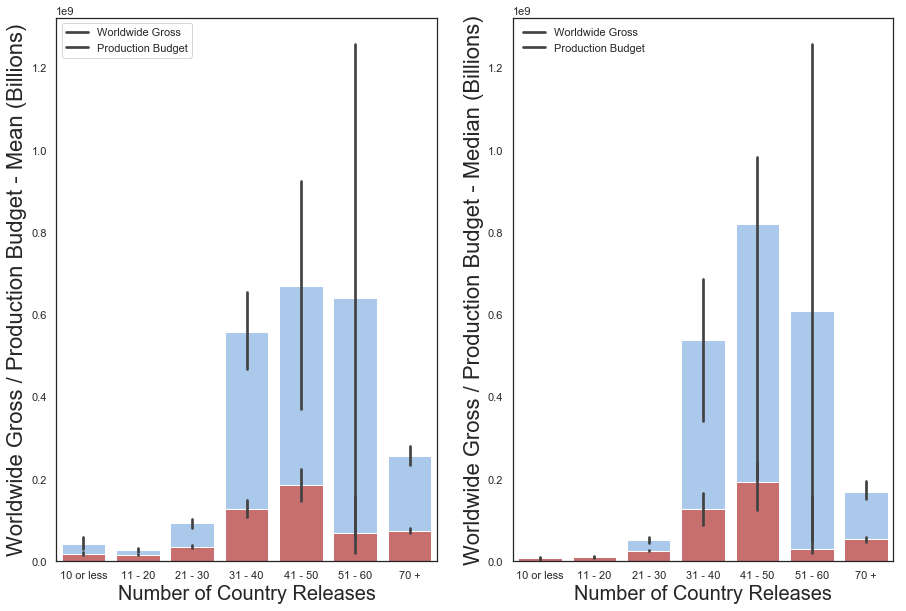

In [466]:
fig = plt.figure(figsize=(15,10))
sns.set(style='white')
order = ['10 or less', '11 - 20', '21 - 30', '31 - 40', '41 - 50', '51 - 60', '70 +']

ax1 = fig.add_subplot(121)

sns.set_color_codes('pastel')
sns.barplot(x='country_count_category',
            y='worldwide_gross',
            data=df_int_movies_analysis,
            color='b',
            order=order,
            estimator=np.mean,
            ax=ax1);

sns.set_color_codes('muted')
sns.barplot(x='country_count_category',
            y='production_budget',
            data=df_int_movies_analysis,
            color='r',
            order=order,
            estimator=np.mean,
            ax=ax1);

plt.legend(['Worldwide Gross', 'Production Budget'])
plt.ylabel('Worldwide Gross / Production Budget - Mean (Billions)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);


ax2 = fig.add_subplot(122)

sns.set_color_codes('pastel')
sns.barplot(x='country_count_category',
            y='worldwide_gross',
            data=df_int_movies_analysis,
            color='b',
            order=order,
            estimator=np.median,
            ax=ax2);

sns.set_color_codes('muted')
sns.barplot(x='country_count_category',
            y='production_budget',
            data=df_int_movies_analysis,
            color='r',
            order=order,
            estimator=np.median,
            ax=ax2);

plt.legend(['Worldwide Gross', 'Production Budget'], frameon=False)
plt.ylabel('Worldwide Gross / Production Budget - Median (Billions)', fontsize=22);
plt.xlabel('Number of Country Releases', fontsize=20);

C:\Users\tcast\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


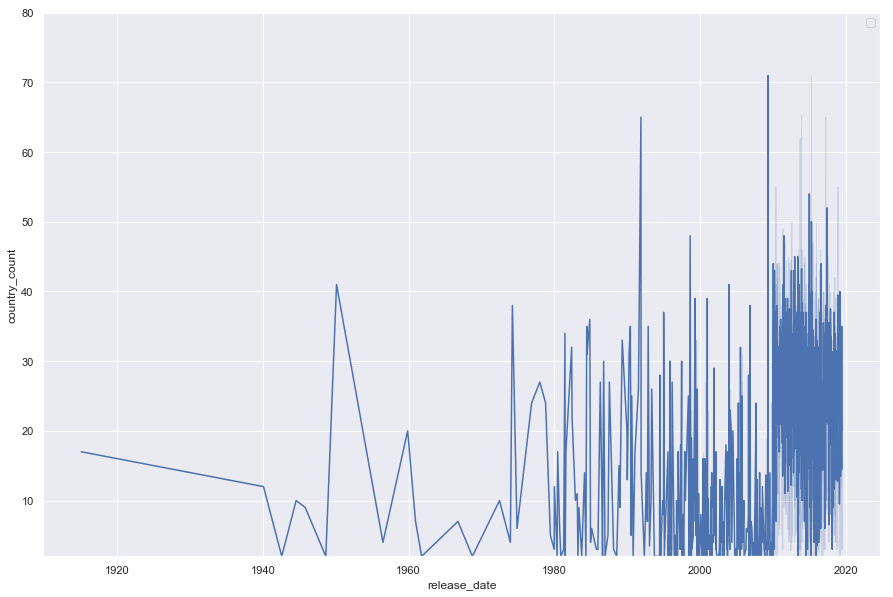

In [423]:
plt.figure(figsize=(15,10))
plt.ylim(2,80)
sns.lineplot(x='release_date', y='country_count', data=df_int_movies_analysis)
# df_country_categories.plot.bar(y='total_profit', rot=0, figsize=(15,10));
# .plot.bar(x='country_count_category', y='total_profit')

plt.legend()

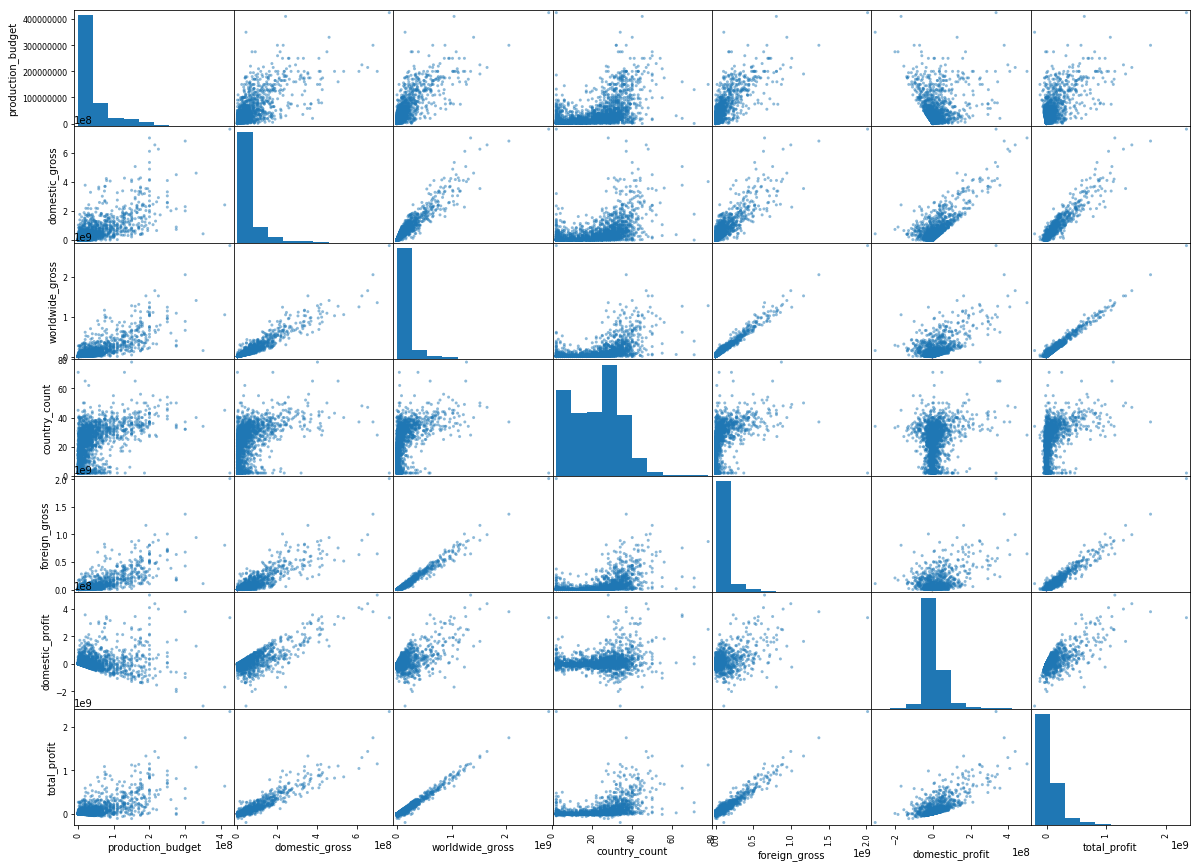

In [236]:
pd.plotting.scatter_matrix(df_int_movies_analysis, figsize=(20,15), grid=True);

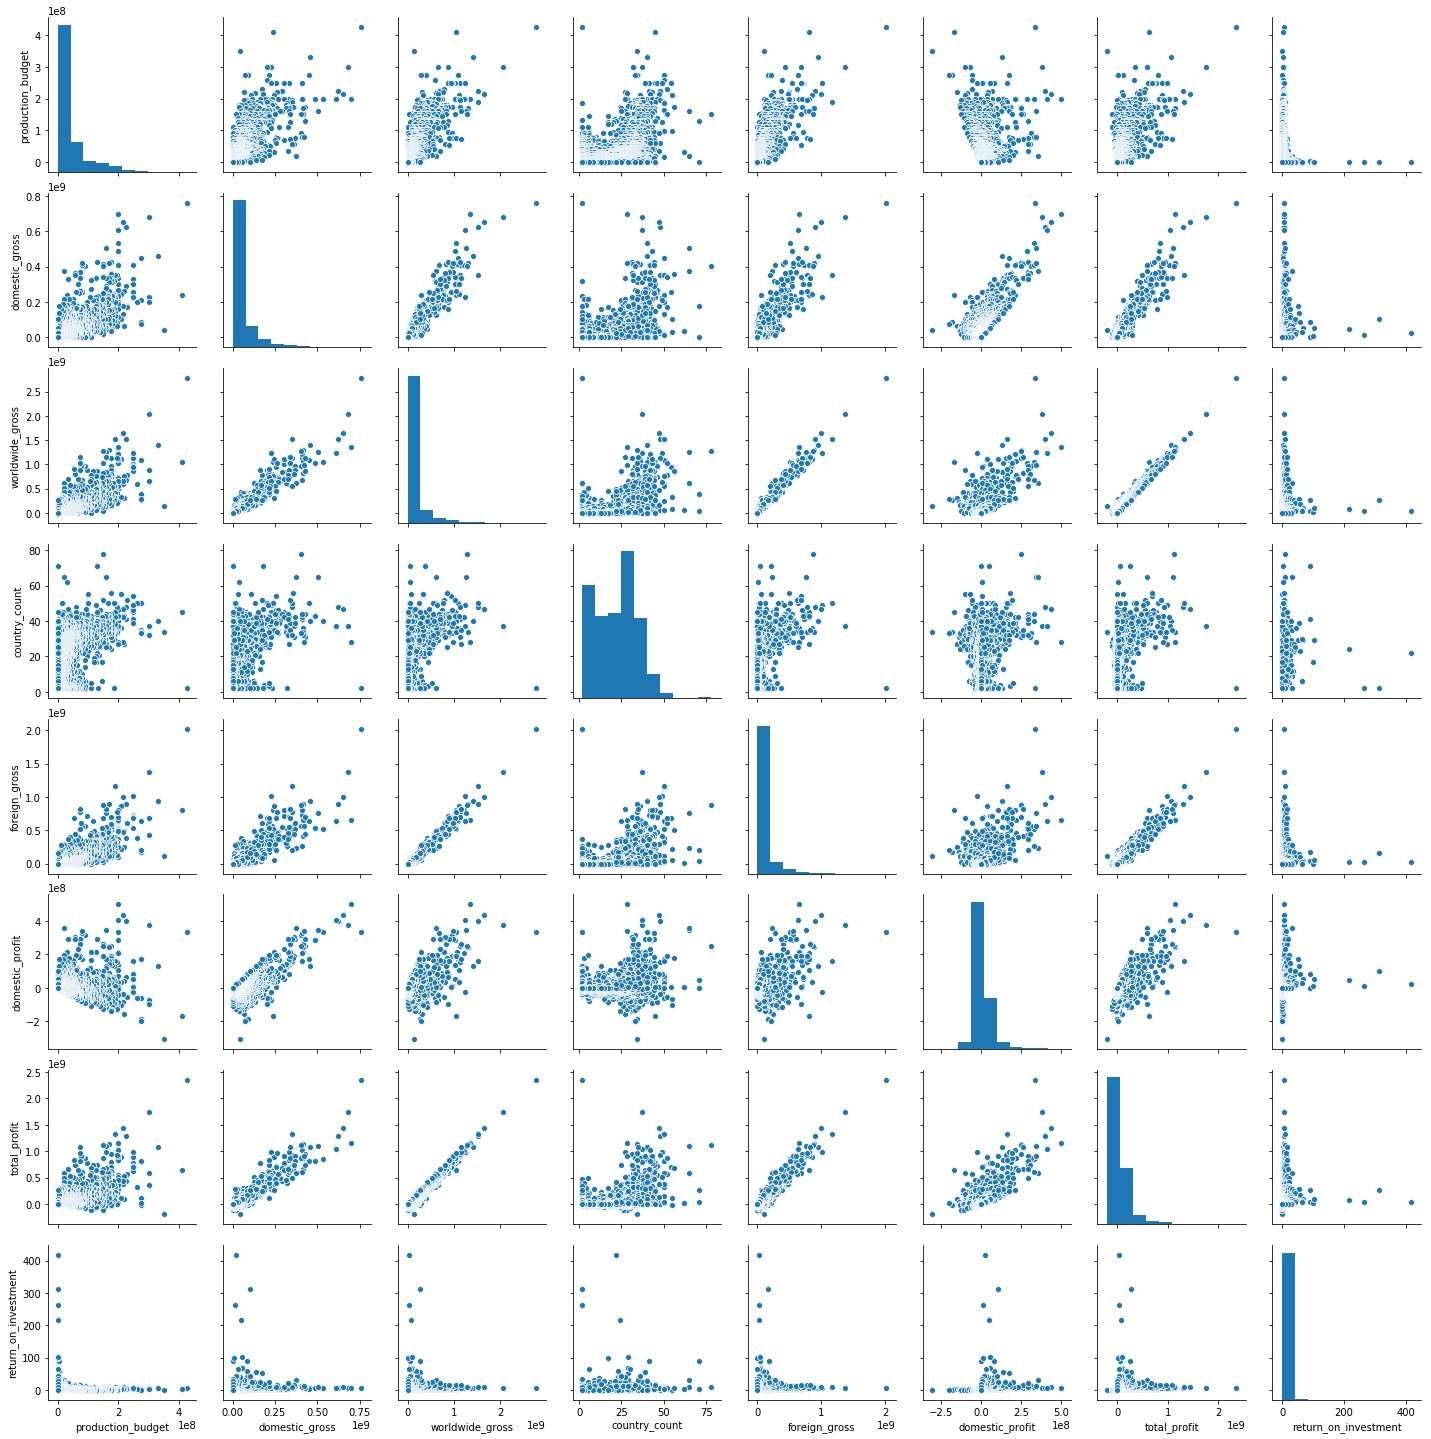

In [263]:
sns.pairplot(df_int_movies_analysis)

In [260]:
# calculate correlation matrix
corr = df_int_movies_analysis.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

In [ ]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, ‘f’))) output
